In [1]:
import networkx as nx
from dowhy import CausalModel
from IPython.display import Image, display
import random, time
import pandas as pd
import numpy as np
import dataframe_image
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelBinarizer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

In [3]:
sd = pd.read_csv('downloads/master.csv').drop(['country-year',
                                               'HDI for year',
                                               'generation',
                                               'suicides_no',
                                               'population',
                                               ' gdp_for_year ($) '], axis=1)
#https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016 
sd['Age Group'] = np.nan
sd.age.unique()
for x in range(len(sd)):
    if sd['age'][x] == '75+ years':
        sd['Age Group'][x] = 75
    else:
        sd['Age Group'][x] = int(sd['age'][x].split('-')[0])

sd.rename(columns = {'suicides/100k pop':'Suicides per 100k'}, inplace = True)
sd.rename(columns = {'gdp_per_capita ($)':'GDP per capita ($)'}, inplace = True)

pop_dense = pd.read_csv('downloads/population_density.csv')[['Country Name']+[str(num) for num in range(1985,2017)]]
#https://data.worldbank.org/indicator/EN.POP.DNST
pop_dense.name = 'Population Density'

elderly_pop = pd.read_csv('downloads/API_SP.POP.65UP.TO.csv')
#https://data.worldbank.org/indicator/SP.POP.65UP.TO.ZS
elderly_pop.name = '% Population > 65'

fertility = pd.read_csv('downloads/BirthsPerWoman.csv')
#https://data.worldbank.org/indicator/SP.DYN.TFRT.IN
fertility.name = 'Births Per Woman'

internet_usage = pd.read_csv('downloads/internetusage.csv')
#https://data.worldbank.org/indicator/IT.NET.USER.ZS
internet_usage.name = '% Population Using Internet'

armed_forces = pd.read_csv('downloads/ArmedForcesProp.csv')
#https://data.worldbank.org/indicator/MS.MIL.TOTL.TF.ZS
armed_forces.name = '% Labour Force in Military'

poverty_rate = pd.read_csv('downloads/PovertyHeadCountRatio.csv')
#https://data.worldbank.org/indicator/SI.POV.NAHC
poverty_rate.name = '% Population in Poverty'

unemployment_rate = pd.read_csv('downloads/UnemploymentRate.csv')
#https://data.worldbank.org/indicator/sl.uem.totl.zs
unemployment_rate.name = 'Unemployment Rate'

for df in [pop_dense,elderly_pop,fertility,internet_usage,armed_forces,poverty_rate,unemployment_rate]:
    sd[df.name] = np.nan
    for x in range(len(sd)):
        if sd.iloc[x]['country'] in list(df['Country Name']) and str(sd.iloc[x]['year']) in df.columns:
            sd[df.name][x] = df[str(sd.iloc[x].year)][list(df['Country Name']).index(sd.iloc[x]['country'])]

urb = pd.read_csv('downloads/urban-and-rural-population.csv')
#https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS
sd['Urbanisation'] = np.nan
for x in range(len(sd)): 
    row = urb.loc[urb['Entity'] == sd.iloc[x].country][urb['Year']==sd.iloc[x].year]
    if row.shape == (1,5):
        sd['Urbanisation'][x] = row['Urban population'].iloc[0]/(row['Urban population'].iloc[0]+row['Rural population'].iloc[0])

In [32]:
sd=sd.dropna()
y_test_variables = sd[['country','sex','year','age']][8000:]
sd.sex = LabelBinarizer().fit_transform(sd.sex)

x_train,x_test,y_train,y_test = [sd[:8000][[x for x in sd.columns if x not in ['level_0','index','Suicides per 100k',
                                                                               'country','age','year']]],
                                sd[8000:][[x for x in sd.columns if x not in ['level_0','index','Suicides per 100k',
                                                                              'country','age','year']]],
                                sd[:8000]['Suicides per 100k'],
                                sd[8000:]['Suicides per 100k']]

x_test

,sex,GDP per capita ($),Age Group,Population Density,% Population > 65,Births Per Woman,% Population Using Internet,% Labour Force in Military,% Population in Poverty,Unemployment Rate,Urbanisation
8000,0,37848,75.0,92.129322,16.522963,1.45,59.600000,0.963271,0.5,11.250,0.77976
8001,0,37848,55.0,92.129322,16.522963,1.45,59.600000,0.963271,0.5,11.250,0.77976
8002,1,37848,15.0,92.129322,16.522963,1.45,59.600000,0.963271,0.5,11.250,0.77976
8003,0,37848,35.0,92.129322,16.522963,1.45,59.600000,0.963271,0.5,11.250,0.77976
8004,0,37848,25.0,92.129322,16.522963,1.45,59.600000,0.963271,0.5,11.250,0.77976
...,...,...,...,...,...,...,...,...,...,...,...
9631,0,441,75.0,58.657947,4.837604,2.36,1.912595,0.697597,82.2,9.072,0.47571
9632,0,441,55.0,58.657947,4.837604,2.36,1.912595,0.697597,82.2,9.072,0.47571
9633,0,441,35.0,58.657947,4.837604,2.36,1.912595,0.697597,82.2,9.072,0.47571
9634,1,441,5.0,58.657947,4.837604,2.36,1.912595,0.697597,82.2,9.072,0.47571


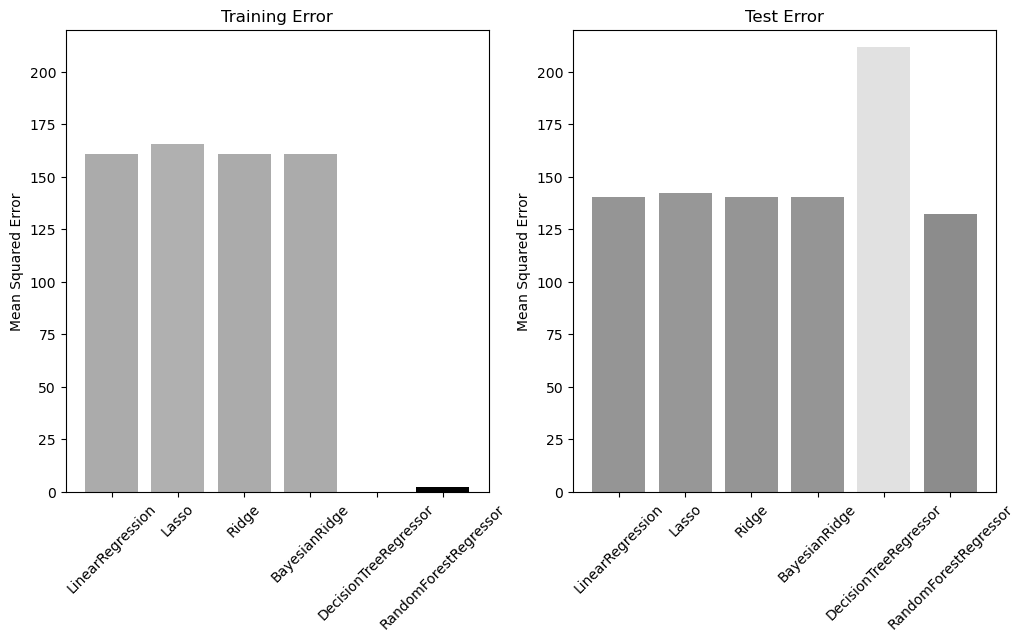

In [1868]:
def mse(targets, predictions):
    return ((targets-predictions)**2).mean()

skls = [LinearRegression, Lasso, Ridge, BayesianRidge, DecisionTreeRegressor, RandomForestRegressor]
training_mses=[mse(y_train, skl().fit(x_train,y_train).predict(x_train)) for skl in skls]
test_mses=[mse(y_test, skl().fit(x_train,y_train).predict(x_test)) for skl in skls]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar([skl.__name__ for skl in skls], training_mses, color=[(i/240,i/240,i/240) for i in training_mses])
plt.xticks(rotation=45)
plt.ylabel('Mean Squared Error')
plt.ylim(0,220)
plt.title('Training Error')
plt.subplot(1,2,2)
plt.bar([skl.__name__ for skl in skls], test_mses, color=[(i/240,i/240,i/240) for i in test_mses])
plt.xticks(rotation=45)
plt.ylabel('Mean Squared Error')
plt.ylim(0,220)
plt.title('Test Error')
plt.show()

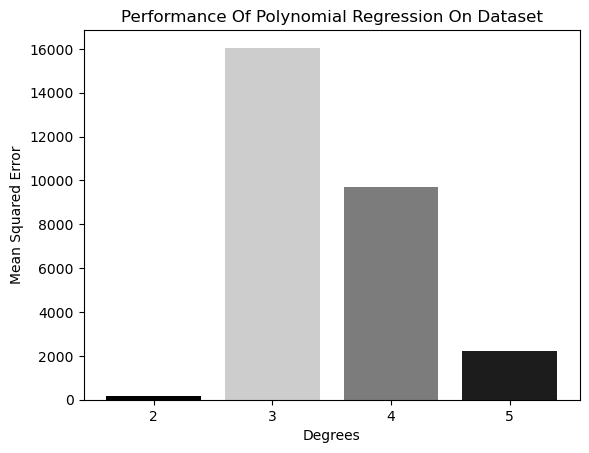

In [1136]:
poly_reg_mse_scores = []
for i in range(2,6):
    poly_reg = make_pipeline(PolynomialFeatures(i), LinearRegression()).fit(x_train,y_train)
    poly_reg_mse_scores.append(mse(poly_reg.predict(x_test), y_test))

plt.bar(['2','3','4','5'], poly_reg_mse_scores, color=[(i/20000,i/20000,i/20000) for i in poly_reg_mse_scores])
plt.title('Performance Of Polynomial Regression On Dataset')
plt.ylabel('Mean Squared Error')
plt.xlabel('Degrees')
plt.show()

In [5]:
class DoWhyRegressor():
    
    def __init__(self):
        self.effects = {}
        self.graph = []
        self.outcome = ''
        self.unobserved_confounders = 0.01
        self.training_errors = []
        self.test_errors = []
        self.unobserved_confounders_history = []
        self.learn_unobserved_confounders = True
        self.epochs = 10
        self.graph_history = []
        self.sensitivity_analysis = True
    
    def get_effects(self, edges, x, y, learning_rate=0.1):
        train = pd.concat([x, y], axis=1)
        train = train[:round(len(train)*0.8)]
        effects = {}
        if self.learn_unobserved_confounders == False:
            iterations = 1
        else:
            iterations = self.epochs
        
        for i in range(iterations):
            for effect in x.columns:
                if self.learn_unobserved_confounders == False:
                    g = nx.DiGraph(edges)
                    nx.write_gml(g, 'mutation.gml')
                    model = CausalModel(data = train,
                                        treatment = effect,
                                        outcome = y.name,
                                        graph = 'mutation.gml')
                else:
                    model = CausalModel(data = train,
                                        common_causes = [i for i in x.columns if i != effect],
                                        treatment = effect,
                                        outcome = y.name)
                identified_effect = model.identify_effect()
                estimate = model.estimate_effect(identified_effect, method_name="backdoor.linear_regression")
                if self.sensitivity_analysis == False:
                    effects[effect] = estimate.value,estimate.intercept
                else:
                    refutation_effects = []
                    for i in range(5):
                        refutation=model.refute_estimate(identified_effect, estimate, 
                                                         method_name="add_unobserved_common_cause",
                                                         confounders_effect_on_treatment="binary_flip", 
                                                         confounders_effect_on_outcome="linear",
                                                         effect_strength_on_treatment=0.01,
                                                         effect_strength_on_outcome=self.unobserved_confounders)
                        refutation_effects.append(refutation.new_effect)
                    effects[effect] = np.array(refutation_effects).mean(),estimate.intercept
            if self.learn_unobserved_confounders == True:
                self.unobserved_confounders_history.append(self.unobserved_confounders)
                y_pred = self.predict(x, effects)
                error = self.mse(y_pred, y)

                self.training_errors.append(error)
                self.test_errors.append(self.mse(self.predict(x_test, effects), y_test))
                deriv = (-2/len(x)) * sum(y - y_pred)
                self.unobserved_confounders -= learning_rate * deriv
        return effects
    
    def predict(self, df, effects={}):
        if effects == {}:
            effects = self.effects
        predictions = []
        intercept = np.array([effects[effect][1] for effect in effects]).mean()
        for i in range(len(df)):        
            predictions.append(sum(np.array([effects[effect][0] for effect in effects])*np.array(df.iloc[i])))
        return np.array(predictions)+intercept
    
    def mse(self, targets, predictions):
        return ((targets-predictions)**2).mean()
    
    def fit(self, x_train, y_train, epochs=10, kfolds=1, graph_model=False, 
            level_of_confounding=0.15, learning_rate=0.1, unobserved_confounders=0.01):

        if kfolds > 1:
            fold_indices = np.linspace(0, len(x_train), kfolds+1)
            candidates = []
            for i in range(kfolds):
                cand = DoWhyRegressor()
                x = x_train[0:round(fold_indices[i])].append(x_train[round(fold_indices[i+1]):])
                y = y_train[0:round(fold_indices[i])].append(y_train[round(fold_indices[i+1]):])
                cand.fit(x, y, epochs, 1, graph_model, level_of_confounding,
                        learning_rate, unobserved_confounders)
                candidates.append((cand.score(x_train,y_train), cand.graph, cand.effects, 
                                   cand.unobserved_confounders))
            selection = min(candidates)
            self.graph, self.effects, self.unobserved_confounders = selection[1], selection[2], selection[3]
            return
        if graph_model == False:
            self.epochs = epochs
            self.effects = self.get_effects([], x_train, y_train, learning_rate)
            return
        
        # code for genetic algorithm
        n = x_train.shape[1]
        self.learn_unobserved_confounders = False
        self.unobserved_confounders = unobserved_confounders
        baseline = [(c, y_train.name) for c in x_train.columns]
        variations = []
        for variation in range(n*2):
            acyclic = False
            while acyclic == False:
                random_dag = nx.DiGraph([(c,e) for (c,e) in nx.gnp_random_graph(n,level_of_confounding,
                                                                                directed=True).edges() if c<e])
                b = nx.DiGraph(baseline)
                for edge in random_dag.edges():
                    b.add_edge(x_train.columns[edge[0]],x_train.columns[edge[1]])
                acyclic = nx.is_directed_acyclic_graph(b)
            effects = self.get_effects(b.edges(),x_train,y_train)
            guess = self.predict(x_train, effects)
            result = self.mse(guess,y_train)
            graph = [edge for edge in b.edges()]
            variations.append((result, graph, effects))
            self.graph_history.append(graph)
            self.training_errors.append(result)
            self.test_errors.append(self.mse(self.predict(x_test, effects), y_test))
        for i in range(epochs-1):
            top_graphs = [sorted(variations)[0][1],sorted(variations)[1][1]]
            for variation in range(n*2):
                acyclic = False
                while (acyclic == False or (graph in self.graph_history)==True)==True:
                    mutation = nx.DiGraph(top_graphs[variation%2])
                    c = random.choice(x_train.columns)
                    e = random.choice([i for i in x_train.columns if i != c])
                    if (c,e) not in mutation.edges():
                        mutation.add_edge(c,e)
                    if (e,c) in mutation.edges():
                        mutation.remove_edge(e,c)
                    else:
                        mutation.remove_edge(c,e)
                    acyclic = nx.is_directed_acyclic_graph(mutation)
                    graph = [edge for edge in mutation.edges()]
                self.graph_history.append(graph)
                effects = self.get_effects(mutation.edges(), x_train, y_train)
                guess = self.predict(x_train, effects)
                result = self.mse(guess, y_train)
                variations.append((result, graph, effects))
                self.training_errors.append(result)
                self.test_errors.append(self.mse(self.predict(x_test, effects), y_test))
        self.effects = min(variations)[2]
        self.graph = min(variations)[1]
    
    def score(self, testx, testy):
        return self.mse(self.predict(testx),testy)
    
    def show_graph(self):
        plt.figure(figsize=(9,6))
        graph = nx.DiGraph(self.graph)
        nx.draw_circular(graph, with_labels=True, node_color='red', edge_color='red')
        

In [ ]:
unsensitive_dw=DoWhyRegressor()
unsensitive_dw.sensitivity_analysis=False
unsensitive_dw.fit(x_train,y_train,epochs=1,graph_model=False)

partial_data_lin=LinearRegression().fit(x_train[:6400],y_train[:6400])
full_data_lin=LinearRegression().fit(x_train,y_train)
coefs = pd.DataFrame()
coefs['Variables']=x_train.columns
coefs['Linear Regression']=full_data_lin.coef_
coefs['Linear Regression (Trained on 80% of Data)']=partial_data_lin.coef_
coefs['DoWhy Regressor Without Deconfounding']=[unsensitive_dw.effects[var][0] for var in coefs['Variables']]

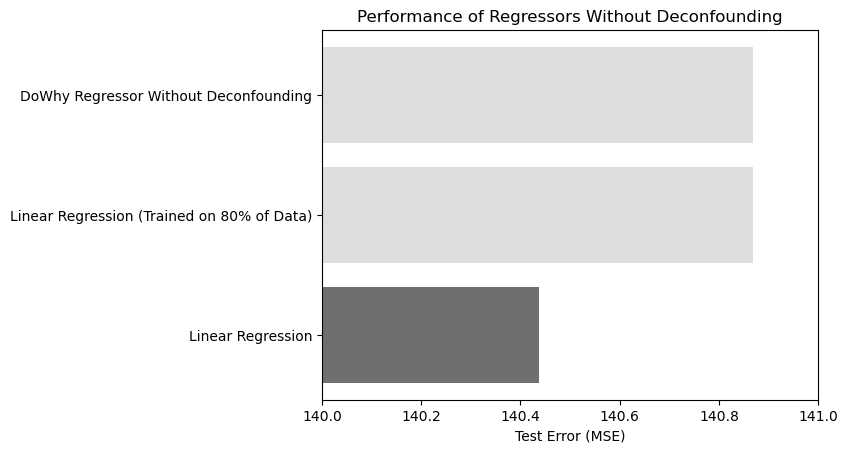

In [1680]:
results=[mse(mod.predict(x_test),y_test) for mod in [full_data_lin,partial_data_lin]]+[unsensitive_dw.score(x_test,
                                                                                                            y_test)]
plt.barh(coefs.columns[1:], results, color=[(i-140,i-140,i-140) for i in results])
plt.xlim(140,141)
plt.xlabel('Test Error (MSE)')
plt.title('Performance of Regressors Without Deconfounding')
plt.show()

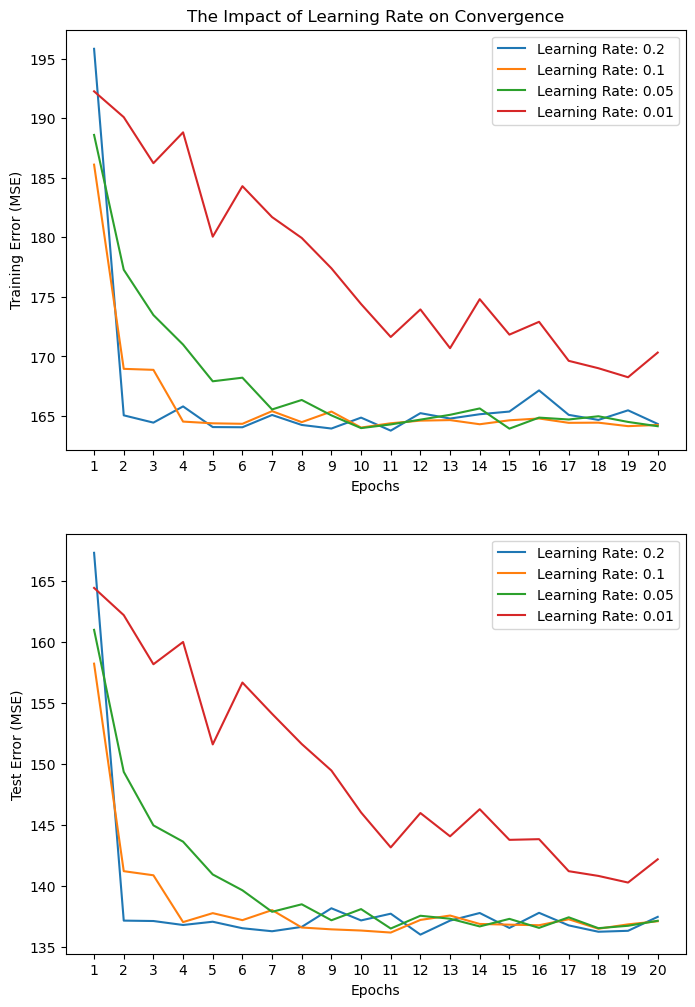

In [1270]:
test_errors = []
learning_rates = [0.2,0.1,0.05,0.01]
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
for i in learning_rates:
    dw = DoWhyRegressor()
    dw.fit(x_train,y_train,learning_rate=i,epochs=20)
    test_errors.append(dw.test_errors)
    x = [i+1 for i in range(len(dw.test_errors))]
    plt.plot(x,dw.training_errors,label=f'Learning Rate: {i}')
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Training Error (MSE)')
plt.title('The Impact of Learning Rate on Convergence')
plt.legend()
plt.subplot(2,1,2)
for i in range(len(learning_rates)):
    plt.plot(x,test_errors[i],label=f'Learning Rate: {learning_rates[i]}')
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Test Error (MSE)')
plt.legend()
plt.show()

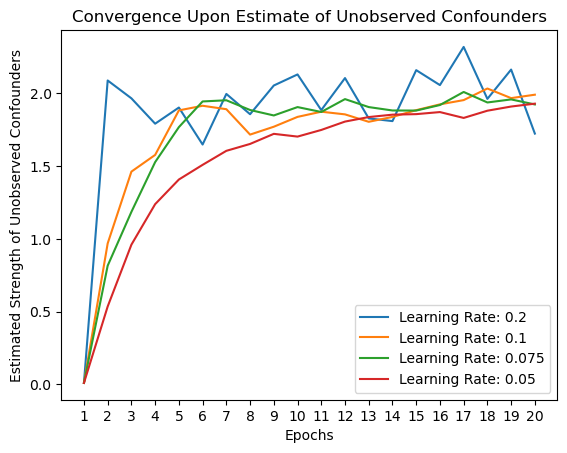

In [1178]:
for i in [0.2,0.1,0.075,0.05]:
    dw = DoWhyRegressor()
    dw.fit(x_train,y_train,learning_rate=i,epochs=20)
    plt.plot([i+1 for i in range(len(dw.unobserved_confounders_history))],
             dw.unobserved_confounders_history,label=f'Learning Rate: {i}')
plt.xticks([i+1 for i in range(len(dw.unobserved_confounders_history))])
plt.xlabel('Epochs')
plt.ylabel('Estimated Strength of Unobserved Confounders')
plt.title('Convergence Upon Estimate of Unobserved Confounders')
plt.legend()
plt.show()

With Unobserved Confounders Set To 0.01, Training MSE = 167.51318424535418
    With Unobserved Confounders Set To 0.01, Test MSE = 161.86022692842118
With Unobserved Confounders Set To 1.0, Training MSE = 236.19631636548291
    With Unobserved Confounders Set To 1.0, Test MSE = 754.7976975078108
With Unobserved Confounders Set To 2.0, Training MSE = 163.85190425399958
    With Unobserved Confounders Set To 2.0, Test MSE = 144.35216495606724


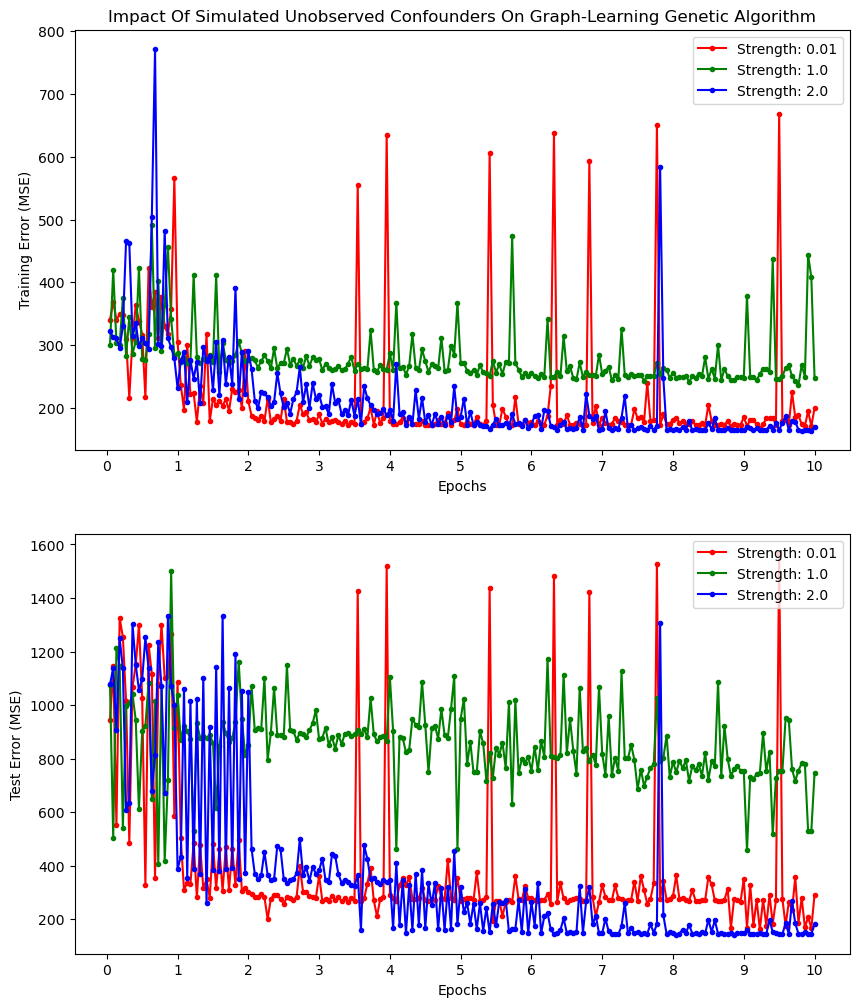

In [1594]:
candidates=[0.01, 1.0, 2.0]
colors=['red','green','blue']
test_errors = []
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
for i in range(3):
    dw = DoWhyRegressor()
    dw.fit(x_train,y_train,level_of_confounding=0.15,unobserved_confounders=candidates[i],
           graph_model=True,mutation_size=1,epochs=10)
    test_errors.append(dw.test_errors)
    x = [i+1 for i in range(len(dw.training_errors))]
    plt.plot(x, dw.training_errors, marker='.', label=f'Strength: {candidates[i]}', color=colors[i])
plt.xlabel('Epochs')
plt.ylabel('Training Error (MSE)')
plt.xticks([i*22 for i in range(11)],[i for i in range(11)])
plt.title('Impact Of Simulated Unobserved Confounders On Graph-Learning Genetic Algorithm')
plt.legend()
plt.subplot(2,1,2)
for i in range(3):
    plt.plot(x, test_errors[i], marker='.', label=f'Strength: {candidates[i]}', color=colors[i])
plt.xlabel('Epochs')
plt.ylabel('Test Error (MSE)')
plt.xticks([i*22 for i in range(11)],[i for i in range(11)])
plt.legend()
plt.show()

With Initial Level of Confounding Set To 0.1, Training MSE = 238.38080799864716
    With Initial Level of Confounding Set To 0.1, Test MSE = 820.6698232228398
With Initial Level of Confounding Set To 0.3, Training MSE = 166.6213196681456
    With Initial Level of Confounding Set To 0.3, Test MSE = 184.83359999115433
With Initial Level of Confounding Set To 0.5, Training MSE = 168.02146185367528
    With Initial Level of Confounding Set To 0.5, Test MSE = 228.19195323137396


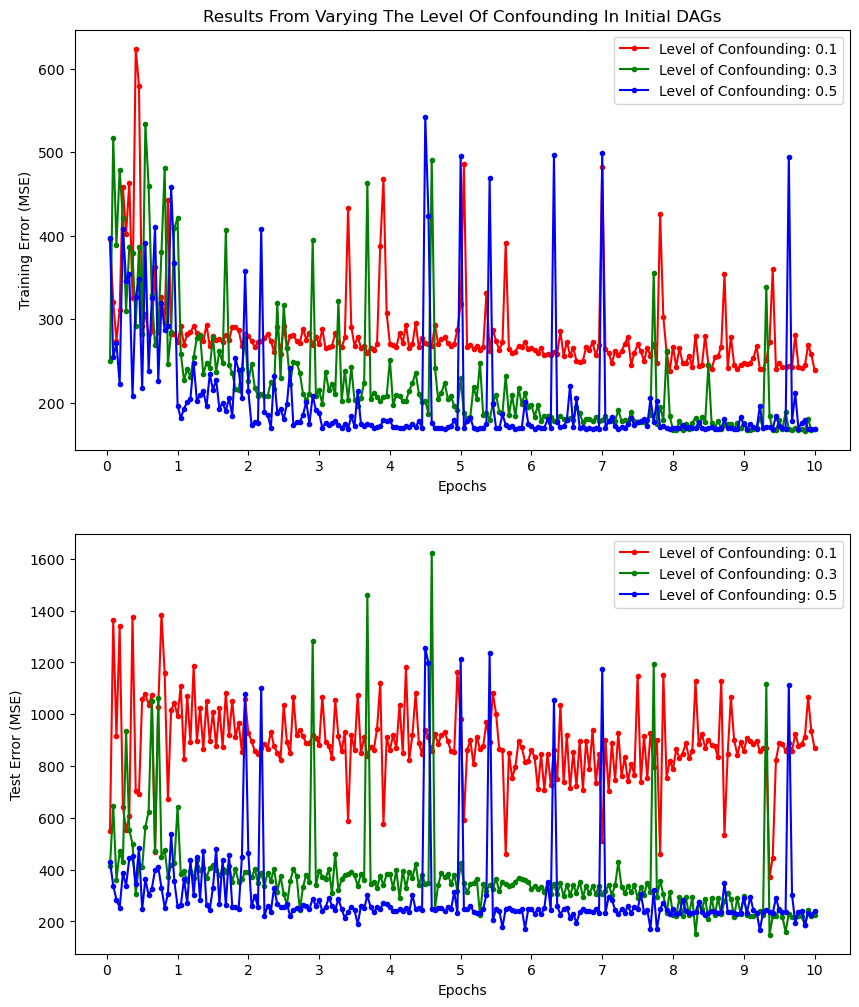

In [1596]:
candidates=[0.1,0.3,0.5]
test_errors = []
tracking = []
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
for i in range(3):
    dw = DoWhyRegressor()
    dw.fit(x_train,y_train,unobserved_confounders=2.0,level_of_confounding=candidates[i],graph_model=True)
    test_errors.append(dw.test_errors)
    tracking.append((dw.graph,dw.effects))
    x = [i+1 for i in range(len(dw.training_errors))]
    plt.plot(x, dw.training_errors,  marker='.', label=f'Level of Confounding: {candidates[i]}', color=colors[i])
    print(f'''With Initial Level of Confounding Set To {candidates[i]}, Training MSE = {dw.score(x_train,y_train)}
    With Initial Level of Confounding Set To {candidates[i]}, Test MSE = {dw.score(x_test,y_test)}''')
plt.xlabel('Epochs')
plt.ylabel('Training Error (MSE)')
plt.xticks([i*22 for i in range(11)],[i for i in range(11)])
plt.title('Results From Varying The Level Of Confounding In Initial DAGs')
plt.legend()
plt.subplot(2,1,2)
for i in range(3):
    plt.plot(x, test_errors[i], marker='.', label=f'Level of Confounding: {candidates[i]}', color=colors[i])
plt.xlabel('Epochs')
plt.ylabel('Test Error (MSE)')
plt.xticks([i*22 for i in range(11)],[i for i in range(11)])
plt.legend()
plt.show()

142.57372727446173


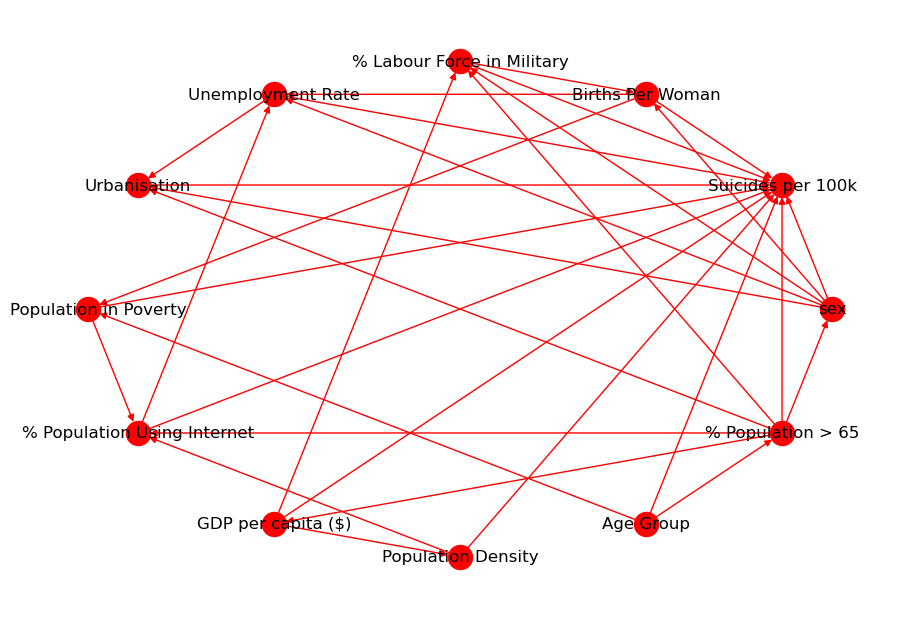

In [1613]:
optimal_graph_learner = DoWhyRegressor()
optimal_graph_learner.fit(x_train, y_train, graph_model=True, unobserved_confounders=2.0, level_of_confounding=0.15)
print(optimal_graph_learner.score(x_test,y_test))
optimal_graph_learner.show_graph()

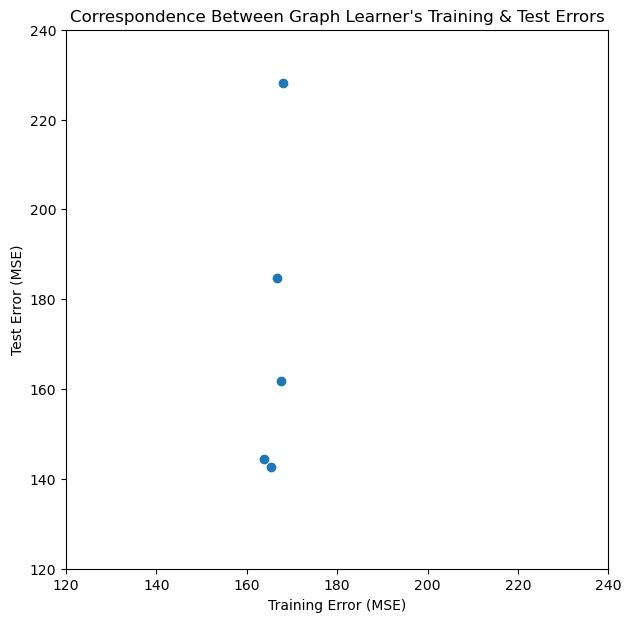

In [1787]:
trains = [167.51318424535418,163.85190425399958,166.6213196681456,168.02146185367528]
tests = [161.86022692842118,144.35216495606724,184.83359999115433,228.19195323137396]
trains += [optimal_graph_learner.score(x_train,y_train)]
tests += [optimal_graph_learner.score(x_test,y_test)]
plt.figure(figsize=(7,7))
plt.scatter(trains,tests)
plt.xlabel('Training Error (MSE)')
plt.ylabel('Test Error (MSE)')
plt.xlim(120,240)
plt.ylim(120,240)
plt.title("Correspondence Between Graph Learner's Training & Test Errors")
plt.show()

In [1737]:
graph_learner = DoWhyRegressor()
u_learner = DoWhyRegressor()
start = time.time()
graph_learner.fit(x_train, y_train, graph_model=True, unobserved_confounders=2.0, level_of_confounding=0.7)
graph_learner_time = time.time()-start
start = time.time()
u_learner.fit(x_train, y_train, graph_model=False)
u_learner_time = time.time()-start
start = time.time()
RandomForestRegressor().fit(x_train,y_train)
random_forest_time = time.time()-start
start = time.time()
LinearRegression().fit(x_train,y_train)
linear_regression_time = time.time()-start

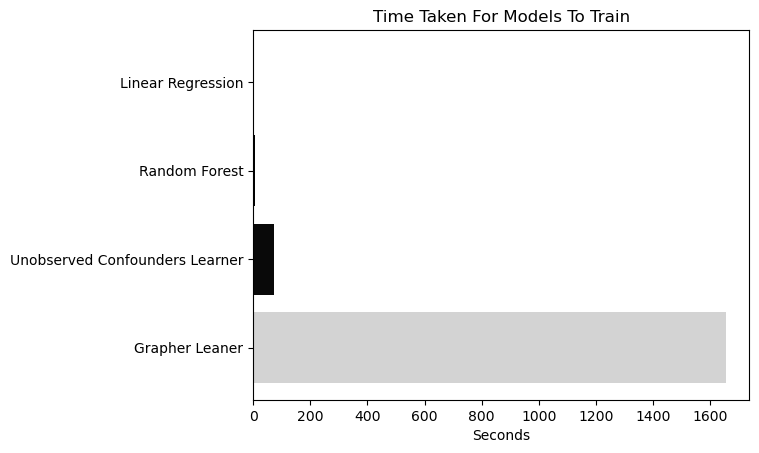

In [1744]:
times = [graph_learner_time, u_learner_time, random_forest_time, linear_regression_time]
plt.barh(['Grapher Leaner','Unobserved Confounders Learner','Random Forest','Linear Regression'],
         times, color=[(i/2000,i/2000,i/2000) for i in times])
plt.xlabel('Seconds')
plt.title('Time Taken For Models To Train')
plt.show()

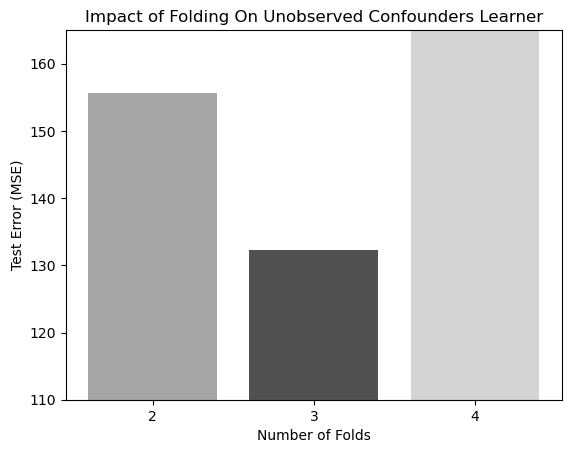

In [1902]:
results = []
for i in [2,3,4]:
    dw=DoWhyRegressor()
    dw.fit(x_train,y_train,epochs=15,kfolds=i,graph_model=False)
    results.append(dw.score(x_test,y_test))
    
plt.bar(['2','3','4'], results, color=[((i-110)/70,(i-110)/70,(i-110)/70) for i in results])
plt.xlabel('Number of Folds')
plt.ylabel('Test Error (MSE)')
plt.ylim(110,165)
plt.title('Impact of Folding On Unobserved Confounders Learner')
plt.show()

In [1908]:
optimal_dw = DoWhyRegressor()
optimal_dw.fit(x_train,y_train,graph_model=False,kfolds=3,epochs=15,learning_rate=0.1)

In [1844]:
kfolds=3
fold_indices = np.linspace(0, len(x_train), kfolds+1)
candidates = []
for i in range(kfolds):
    cand = RandomForestRegressor()
    x = x_train[0:round(fold_indices[i])].append(x_train[round(fold_indices[i+1]):])
    y = y_train[0:round(fold_indices[i])].append(y_train[round(fold_indices[i+1]):])
    cand.fit(x, y)
    candidates.append((cand.score(x_train,y_train), mse(cand.predict(x_test),y_test)))
kfolded_random_forest=max(candidates)[1]

candidates = []
for i in range(kfolds):
    cand = LinearRegression()
    x = x_train[0:round(fold_indices[i])].append(x_train[round(fold_indices[i+1]):])
    y = y_train[0:round(fold_indices[i])].append(y_train[round(fold_indices[i+1]):])
    cand.fit(x, y)
    candidates.append((cand.score(x_train,y_train), mse(cand.predict(x_test),y_test), cand.coef_))
kfolded_lin, kfolded_coef = max(candidates)[1], max(candidates)[2]

results = [mse(LinearRegression().fit(x_train,y_train).predict(x_test),y_test), kfolded_lin,
        mse(RandomForestRegressor().fit(x_train,y_train).predict(x_test),y_test), kfolded_random_forest,
        dw.score(x_test,y_test), optimal_dw.score(x_test,y_test), optimal_graph_learner.score(x_test,y_test)]

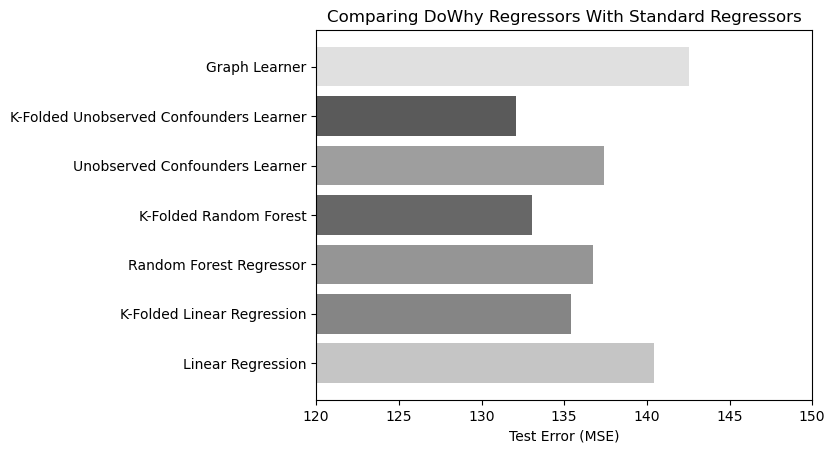

In [1869]:
plt.barh(['Linear Regression', 'K-Folded Linear Regression', 'Random Forest Regressor', 'K-Folded Random Forest',
         'Unobserved Confounders Learner', 'K-Folded Unobserved Confounders Learner','Graph Learner'],
       results, color=[((i-125)/20,(i-125)/20,(i-125)/20) for i in results])
plt.xlabel('Test Error (MSE)')
plt.xlim(120,150)
plt.title('Comparing DoWhy Regressors With Standard Regressors')
plt.show()

In [1722]:
y_pred = optimal_dw.predict(x_test)
outcomes = pd.concat([y_test_variables,((y_test-y_pred)**2).to_frame(name='MSE')],axis=1)
outcomes_comparison = pd.concat([y_test_variables,((y_test-y_pred)**2).to_frame(name='MSE')],axis=1)
outcomes_comparison['Prediction'] = y_pred
outcomes_comparison['Actual Data'] = y_test
for i in range(len(outcomes)):
    if outcomes_comparison['sex'].iloc[i] == 'male':
        outcomes_comparison['sex'].iloc[i] = 'Male'
    else:
        outcomes_comparison['sex'].iloc[i] = 'Female'

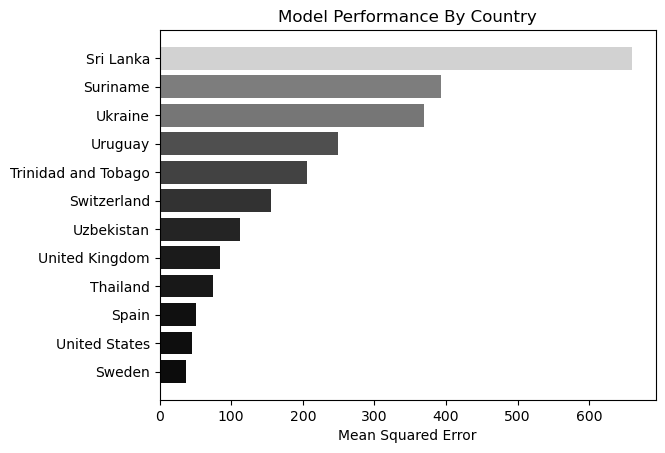

In [1856]:
mse_by_variable = outcomes_comparison.groupby('country').mean().sort_values(('MSE'))
plt.barh(mse_by_variable.index, mse_by_variable['MSE'], color=[(i/800,i/800,i/800) for i in mse_by_variable['MSE']])
plt.title('Model Performance By Country')
plt.xlabel('Mean Squared Error')
plt.show() 

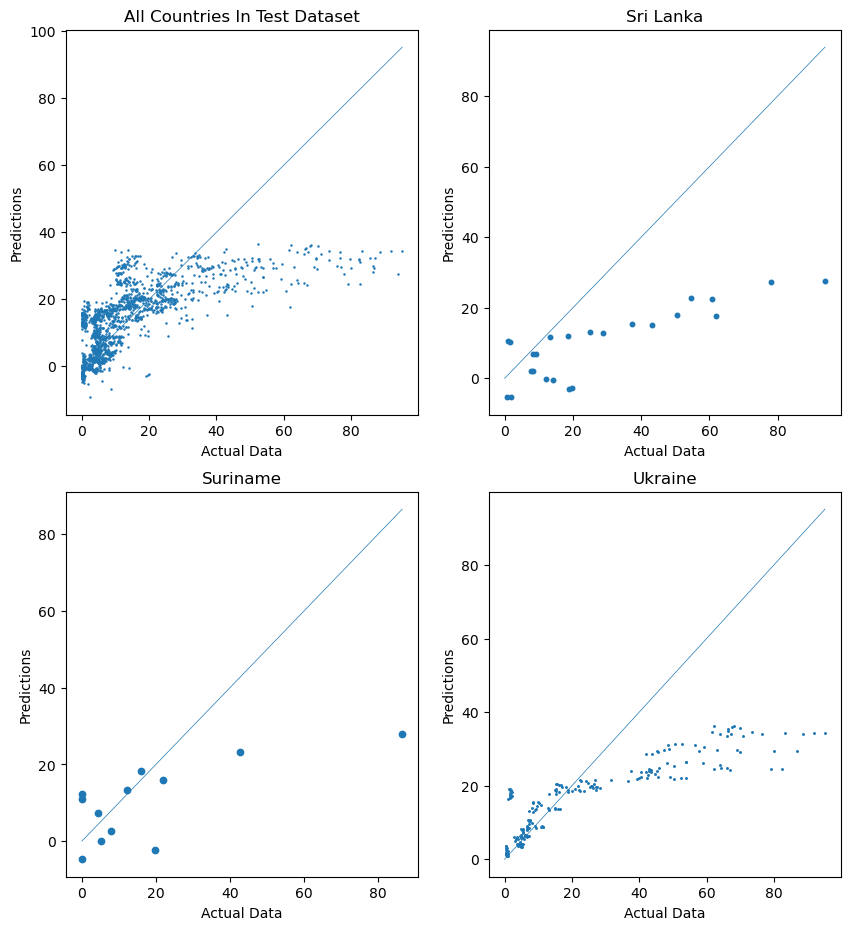

In [1724]:
plt.figure(figsize=(10,11))
plt.subplot(2,2,1)
plt.scatter(outcomes_comparison['Actual Data'],outcomes_comparison['Prediction'],s=1000/len(outcomes_comparison))
plt.plot([0,max(np.append(y_test,y_pred))],[0,max(np.append(y_test,y_pred))],linewidth=0.5)
plt.xlabel('Actual Data')
plt.ylabel('Predictions')
plt.title('All Countries In Test Dataset')
subplot = 2
for nation in ['Sri Lanka','Suriname','Ukraine']:
    data = outcomes_comparison[outcomes_comparison.country.isin([nation])]
    plt.subplot(2,2,subplot)
    plt.scatter(data['Actual Data'],data['Prediction'],s=250/len(data))
    plt.plot([0,max(data['Actual Data'])],[0,max(data['Actual Data'])],linewidth=0.5)
    plt.xlabel('Actual Data')
    plt.ylabel('Predictions')
    plt.title(nation)
    subplot +=1

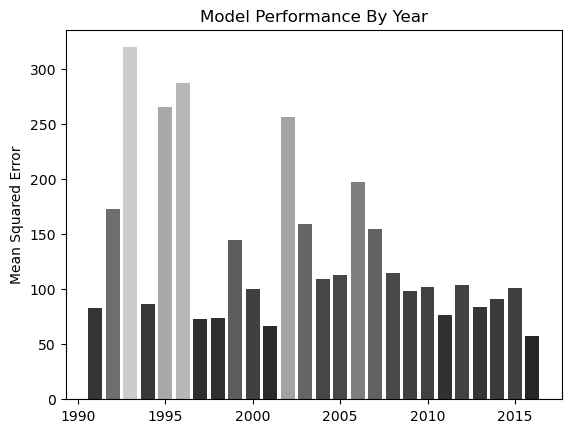

In [1855]:
mse_by_year = outcomes_comparison.groupby('year').mean()
plt.bar(mse_by_year.index, mse_by_year['MSE'], color=[(i/400,i/400,i/400) for i in mse_by_year['MSE']])
plt.ylabel('Mean Squared Error')
plt.title('Model Performance By Year')
plt.show()

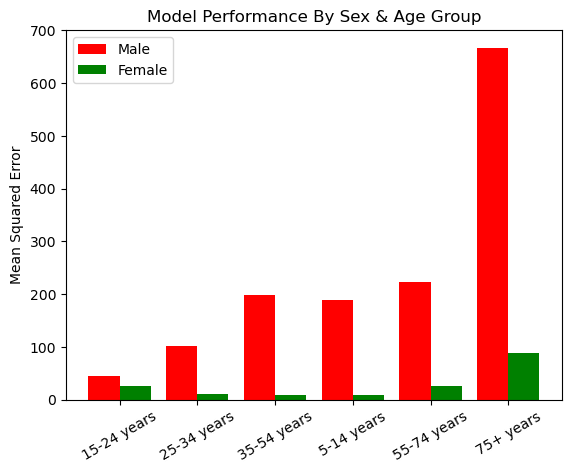

In [1726]:
for s in [('Male',-0.2,'red'),('Female',0.2,'green')]:
    data = outcomes_comparison[outcomes_comparison.sex.isin([s[0]])].groupby('age').mean()
    plt.bar(np.arange(6)+s[1],data['MSE'],width=0.4,label=s[0],color=s[2])
plt.legend()
plt.xticks([i for i in range (6)], data.index, rotation=30)
plt.ylabel('Mean Squared Error')
plt.title('Model Performance By Sex & Age Group')
plt.show()

In [1888]:
lin = LinearRegression().fit(x_train,y_train)
effects_comparison = pd.DataFrame()
effects_comparison['Variables'] = x_train.columns
effects_comparison['Linear Regression'] = lin.coef_.round(5)
effects_comparison['K-Folded Linear Regresson'] = kfolded_coef.round(5)
effects_comparison['DoWhy ATEs'] = np.array([optimal_dw.effects[var][0] for var in effects_comparison['Variables']]).round(5)

effects_comparison

,Variables,Linear Regression,K-Folded Linear Regresson,DoWhy ATEs
0,sex,15.10498,15.64935,15.71601
1,GDP per capita ($),-0.00008,-0.00006,-0.00005
2,Age Group,0.26470,0.26692,0.24295
3,Population Density,-0.00951,-0.01110,-0.01047
4,% Population > 65,0.93392,1.24119,0.87637
5,Births Per Woman,0.10494,-0.94504,0.59266
6,% Population Using Internet,-0.02108,-0.05790,-0.03786
7,% Labour Force in Military,-0.82598,-0.84757,-0.61022
8,% Population in Poverty,-0.17087,-0.01623,0.08824
9,Unemployment Rate,-0.28194,-0.27738,-0.20048


In [1884]:
scaler=StandardScaler()
scaler.fit(pd.concat([x_train,x_test]))
scaled_x_train, scaled_x_test = scaler.transform(x_train), scaler.transform(x_test)
trained_on_scaled_data = LinearRegression().fit(scaled_x_train, y_train)
scaled_effects_comparison = effects_comparison
proportion = trained_on_scaled_data.coef_/effects_comparison['Linear Regression']
for column in effects_comparison.columns[1:]:
    scaled_effects_comparison[column] = (np.array(effects_comparison[column])*np.array(proportion)).round(3)
scaled_effects_comparison

,Variables,Linear Regression,K-Folded Linear Regresson,DoWhy ATEs
0,sex,7.552,7.835,7.868
1,GDP per capita ($),-1.795,-1.346,-1.122
2,Age Group,6.296,6.349,5.779
3,Population Density,-1.619,-1.879,-1.782
4,% Population > 65,4.691,6.234,4.402
5,Births Per Woman,0.062,-0.525,0.328
6,% Population Using Internet,-0.658,-1.818,-1.192
7,% Labour Force in Military,-0.810,-0.832,-0.599
8,% Population in Poverty,-1.269,-0.120,0.655
9,Unemployment Rate,-1.232,-1.212,-0.876
